<a href="https://colab.research.google.com/github/angelh-16/nhanes_inferential_2021_23/blob/main/nhanes_inferential_2021_23_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages

In [1]:
# Install packages
install.packages(c("haven", "dplyr", "ggplot2"))
library(haven)
library(ggplot2)
library(dplyr)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Download and convert XPT files to CSV

In [2]:
# Downloaded XPT files to this folder
data_folder <- "/content/data"

# Folder for save CSVs
csv_folder  <- "/content/csv"

# List of NHANES XPT files
xpt_files <- c(
  "BPXO_L.XPT",
  "DEMO_L.XPT",
  "HEPB_S_L.XPT",
  "KIQ_U_L.XPT",
  "PAQ_L.XPT",
  "VID_L.XPT",
  "WHQ_L.XPT"
)

# Loop through all XPT files in folder
for (file in xpt_files) {
  xpt_path <- file.path(data_folder, file)
  csv_path <- file.path(csv_folder, sub("\\.XPT$", ".csv", file))

  tryCatch({
    df <- haven::read_xpt(xpt_path)
    write.csv(df, csv_path, row.names = FALSE)

    message(sprintf("Converted %s to %s", file, basename(csv_path)))
  }, error = function(e) {
    message(sprintf("Failed to convert %s: %s", file, e$message))
  })
}

Converted BPXO_L.XPT to BPXO_L.csv

Converted DEMO_L.XPT to DEMO_L.csv

Converted HEPB_S_L.XPT to HEPB_S_L.csv

Converted KIQ_U_L.XPT to KIQ_U_L.csv

Converted PAQ_L.XPT to PAQ_L.csv

Converted VID_L.XPT to VID_L.csv

Converted WHQ_L.XPT to WHQ_L.csv



In [3]:
# Load CSV into a dataframe
bpxo <- read.csv("/content/csv/BPXO_L.csv")
demo <- read.csv("/content/csv/DEMO_L.csv")
hepb <- read.csv("/content/csv/HEPB_S_L.csv")
kiq  <- read.csv("/content/csv/KIQ_U_L.csv")
paq  <- read.csv("/content/csv/PAQ_L.csv")
vid  <- read.csv("/content/csv/VID_L.csv")
whq  <- read.csv("/content/csv/WHQ_L.csv")

In [4]:
# Confirm load successful
dfs <- list(
  BPXO = bpxo,
  DEMO = demo,
  HEPB = hepb,
  KIQ  = kiq,
  PAQ  = paq,
  VID  = vid,
  WHQ  = whq
)

for (name in names(dfs)) {
  df_ <- dfs[[name]]
  cat(sprintf("%-5s : %d rows, %d columns\n", name, nrow(df_), ncol(df_)))
}

BPXO  : 7801 rows, 12 columns
DEMO  : 11933 rows, 27 columns
HEPB  : 8611 rows, 3 columns
KIQ   : 7809 rows, 9 columns
PAQ   : 8153 rows, 8 columns
VID   : 8727 rows, 10 columns
WHQ   : 8501 rows, 5 columns


Data clean up & recoding

In [5]:
# Replaces the placeholder values 7777 and 9999
clean_placeholder <- function(x) {
  x[x %in% c(7777, 9999)] <- NA
  return(x)
}# Make copies of dataframes so original not modified
bpxo_copy <- bpxo
demo_copy <- demo
hepb_copy <- hepb
kiq_copy  <- kiq
paq_copy  <- paq
vid_copy  <- vid
whq_copy  <- whq

In [6]:
# Marital Status (DMDMARTZ) - categorical, needs recoding (married or not married)
recode_married <- function(x) {
  if (is.na(x) || x %in% c(77, 99)) return(NA)  # Missing/Refused/Don't know
  if (x == 1) return(1)  # Married/Living with partner
  return(0)  # Widowed/Divorced/Separated/Never married
}
if ("DMDMARTZ" %in% names(demo)) {
  demo$married <- sapply(demo$DMDMARTZ, recode_married)
} else {
  demo$married <- NA
}

# Education Level (DMDEDUC2) - categorical, needs recoding (bachelor’s or higher vs. less than bachelor’s)
recode_educ <- function(x) {
  if (is.na(x) || x %in% c(7, 9)) return(NA)  # Missing/refused/don't know
  if (x == 5) return(1)  # Bachelor’s or higher
  return(0)  # Less than bachelor’s
}
if ("DMDEDUC2" %in% names(demo)) {
  demo$education <- sapply(demo$DMDEDUC2, recode_educ)
} else {
  demo$education <- NA
}

# Age in Years (RIDAGEYR) - continuous
clean_age <- function(x) {
  if (is.na(x)) return(NA)
  x <- as.numeric(x)
  if (x >= 0 && x <= 79) return(x)
  if (x == 80) return("80+")  # 80 years of age and over
  return(NA)
}
if ("RIDAGEYR" %in% names(demo)) {
  demo$age <- sapply(demo$RIDAGEYR, clean_age)
} else {
  demo$age <- NA
}

# Systolic Blood Pressure (BPXOSY3) - continuous
# Diastolic Blood Pressure (BPXODI3) - continuous
for (col in c("BPXOSY3", "BPXODI3")) {
  if (col %in% names(bpxo)) {
    bpxo[[col]] <- clean_placeholder(bpxo[[col]])
  }
}

# Vitamin D Lab Interpretation (LBDVD2LC) - categorical, two levels
recode_vitd <- function(x) {
  if (is.na(x)) return(NA)
  if (x == 1) return("Deficient")  #	Below lower detection limit
  if (x == 0) return("Sufficient")  # At or above the detection limit
  return(NA)
}
if ("LBDVD2LC" %in% names(vid)) {
  vid$vitd_status <- sapply(vid$LBDVD2LC, recode_vitd)
} else {
  vid$vitd_status <- NA
}

# Hepatitis B Lab Antibodies (LBXHBS) - categorical, needs recoding to two levels
recode_hbs <- function(x) {
  if (is.na(x)) return(NA)
  if (x == 1) return("Positive")  # Positive
  if (x == 2) return("Negative")  # Negative
  return(NA)
}
if ("LBXHBS" %in% names(hepb)) {
  hepb$hbs_status <- sapply(hepb$LBXHBS, recode_hbs)
} else {
  hepb$hbs_status <- NA
}

# Weak/Failing Kidneys (KIQ022) - categorical, can be treated as two levels
if ("KIQ022" %in% names(kiq)) {
  kiq$KIQ022 <- clean_placeholder(kiq$KIQ022)
  recode_kidney <- function(x) {
    if (is.na(x)) return(NA)
    if (x == 1) return("Yes")  # Yes
    if (x == 2) return("No")  # No
    return(NA)
  }
  kiq$kidney_problem <- sapply(kiq$KIQ022, recode_kidney)
} else {
  kiq$kidney_problem <- NA
}

# Minutes of Sedentary Behavior (PAD680) - continuous, needs cleaning (remove values 7777, 9999, and null)
if ("PAD680" %in% names(paq)) {
  paq$PAD680 <- clean_placeholder(paq$PAD680)
}

# Current Self-Reported Weight (WHD020) - continuous, needs cleaning (remove values 7777, 9999, and null)
if ("WHD020" %in% names(whq)) {
  whq$WHD020 <- clean_placeholder(whq$WHD020)
}

Merge datasets and check

In [7]:
# Start with DEMO as base
merged <- demo

# Add datasets to DEMO
dfs_to_merge <- list(bpxo, paq, whq, vid, hepb, kiq)

for (df in dfs_to_merge) {
  if ("SEQN" %in% names(df)) {
    merged <- merged %>% left_join(df, by = "SEQN")
  }
}

# Check shape
cat("Merged data dimensions:", nrow(merged), "rows,", ncol(merged), "columns\n")
head(merged)

# Check missing values
missing_counts <- sapply(merged, function(x) sum(is.na(x)))
missing_counts <- sort(missing_counts, decreasing = TRUE)
head(missing_counts, 10)

# Check value counts for categorical recodes
categorical_cols <- c("married", "education", "vitd_status", "hbs_status", "kidney_problem")

for (col in categorical_cols) {
  if (col %in% names(merged)) {
    cat("\n", col, "value counts:\n")
    print(table(merged[[col]], useNA = "ifany"))
  }
}

# Check
continuous_cols <- c("RIDAGEYR", "PAD680", "WHD020", "BPXOSY3")
if (all(continuous_cols %in% names(merged))) {
  summary(merged[, continuous_cols])
}

Merged data dimensions: 11933 rows, 74 columns


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,⋯,hbs_status,KIQ022,KIQ025,KIQ005,KIQ010,KIQ042,KIQ044,KIQ052,KIQ481,kidney_problem
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,130378,12,2,1,43,NA,5,6,2,NA,⋯,Negative,2,NA,NA,NA,NA,NA,NA,NA,No
2,130379,12,2,1,66,NA,3,3,2,NA,⋯,Negative,2,NA,2,2,1,2,2,2,No
3,130380,12,2,2,44,NA,2,2,1,NA,⋯,Negative,2,NA,1,NA,2,2,NA,2,No
4,130381,12,2,2,5,NA,5,7,1,71,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,130382,12,2,1,2,NA,3,3,2,34,⋯,Negative,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,130383,12,1,2,3,NA,2,2,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


KIQ025 RIDAGEMN RIDEXPRG DMDYRUSR DMDHSEDZ   KIQ010   KIQ052 RIDEXAGM 
   11612    11556    10430    10058     9806     9609     9390     9146 
  PAD820 DMDHREDZ 
    8246     8187


 married value counts:

   0    1 <NA> 
3647 4136 4150 

 education value counts:

   0    1 <NA> 
5158 2625 4150 

 vitd_status value counts:

 Deficient Sufficient       <NA> 
      5860       1447       4626 

 hbs_status value counts:

Negative Positive     <NA> 
    5324     2042     4567 

 kidney_problem value counts:

  No  Yes <NA> 
7473  321 4139 


    RIDAGEYR         PAD680           WHD020         BPXOSY3     
 Min.   : 0.00   Min.   :   0.0   Min.   : 63.0   Min.   : 50.0  
 1st Qu.:13.00   1st Qu.: 180.0   1st Qu.:145.0   1st Qu.:106.0  
 Median :37.00   Median : 300.0   Median :173.0   Median :116.0  
 Mean   :38.32   Mean   : 362.2   Mean   :179.5   Mean   :118.9  
 3rd Qu.:62.00   3rd Qu.: 480.0   3rd Qu.:205.0   3rd Qu.:129.0  
 Max.   :80.00   Max.   :1380.0   Max.   :530.0   Max.   :232.0  
                 NA's   :3868     NA's   :3575    NA's   :4453   

 - **Question 1**: "Is there **an association** between marital status (married or not married) and education level (bachelor’s degree or higher vs. less than a bachelor’s degree)?"  
     - Variables: `DMDMARTZ` (marital status) and `DMDEDUC2` (education level). Recode as specified.

In [8]:
# Merge varibles together and drop missing values
q1 <- merged %>% select(married, education) %>% na.omit()

# Create contingency table
table_q1 <- table(q1$married, q1$education)

# Rename table rows and columns
rownames(table_q1) <- c("Not married", "Married")
colnames(table_q1) <- c("Less than bachelor", "Bachelor or higher")

# Conduct Chi-square test to see association
chi_res <- chisq.test(table_q1)

# Display table
print(table_q1)
cat("\n")

cat(sprintf("Chi-square statistic = %.3f\n", chi_res$statistic))
cat(sprintf("Degrees of freedom = %d\n", chi_res$parameter))
cat(sprintf("P-value = %.4g\n", chi_res$p.value))
cat(sprintf("Sample size (n) = %d\n", nrow(q1)))

# Results
if (chi_res$p.value < 0.05) {
  cat("\nResult: There is an association between marital status and education level (p < 0.05).\n")
} else {
  cat("\nResult: There is no association between marital status and education level (p ≥ 0.05).\n")
}

             
              Less than bachelor Bachelor or higher
  Not married               2648                990
  Married                   2503               1631

Chi-square statistic = 129.174
Degrees of freedom = 1
P-value = 6.213e-30
Sample size (n) = 7772

Result: There is an association between marital status and education level (p < 0.05).


- **Question 2**: "Is there a difference in the mean sedentary behavior time between those who are married and those who are not married?"  
     - Variables: `DMDMARTZ` (marital status, recoded) and `PAD680` (sedentary behavior time, cleaned).

# A tibble: 2 × 4
  married count  mean    sd
    <dbl> <int> <dbl> <dbl>
1       0  3603  372.  220.
2       1  4106  353.  204.
t-test: t = 3.851, p = 0.0001184

Result: There is a difference in the mean sedentary behavior time between those who are married and those who are not married (p < 0.05).


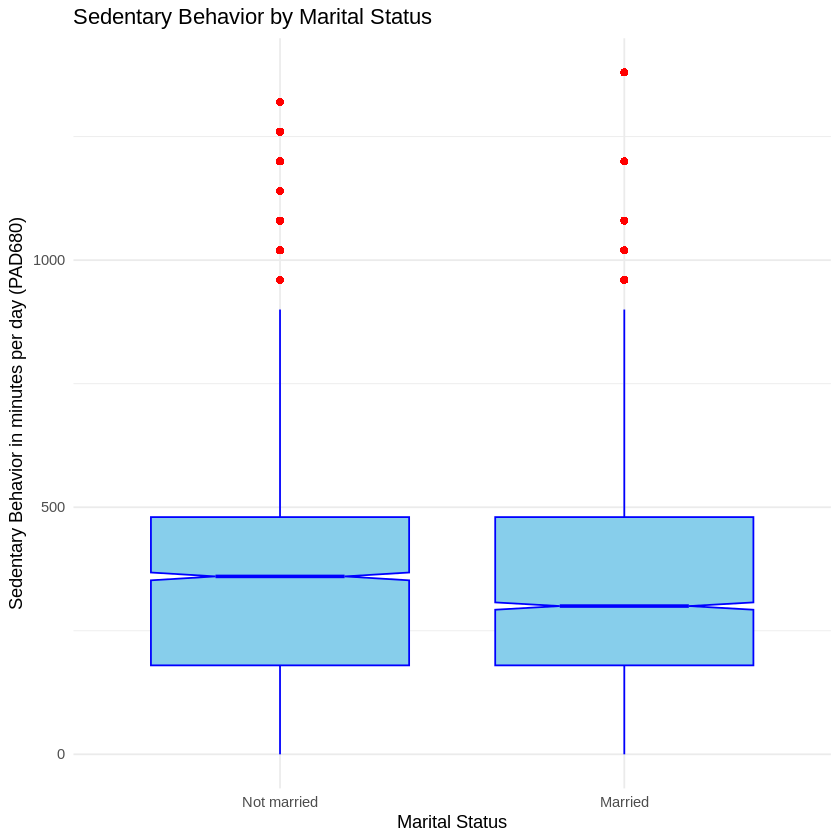

In [9]:
# Merge varibles together and drop missing values
q2 <- merged %>% select(married, PAD680) %>% na.omit()

# Create a table with two varibles
table_q2 <- q2 %>%
  group_by(married) %>%
  summarise(
    count = n(),
    mean  = mean(PAD680, na.rm = TRUE),
    sd    = sd(PAD680, na.rm = TRUE)
  )

print(table_q2)

mar0 <- q2$PAD680[q2$married == 0]  # Not married
mar1 <- q2$PAD680[q2$married == 1]  # Married

# Conduct t test
t_res <- t.test(mar0, mar1, var.equal = FALSE)

cat(sprintf("t-test: t = %.3f, p = %.4g\n\n", t_res$statistic, t_res$p.value))

# Generate boxplot
ggplot(q2, aes(x = factor(married, labels = c("Not married", "Married")), y = PAD680)) +
  geom_boxplot(notch = TRUE, fill = "skyblue", color = "blue", outlier.color = "red", outlier.shape = 16, outlier.size = 2) +
  labs(
    x = "Marital Status",
    y = "Sedentary Behavior in minutes per day (PAD680)",
    title = "Sedentary Behavior by Marital Status"
  ) +
  theme_minimal()

# Results
if (t_res$p.value < 0.05) {
  cat("Result: There is a difference in the mean sedentary behavior time between those who are married and those who are not married (p < 0.05).\n")
} else {
  cat("Result: There is no difference in the mean sedentary behavior time between those who are married and those who are not married (p ≥ 0.05).\n")
}

   - **Question 3**: "How do age and marital status affect systolic blood pressure?"  
     - Variables: `RIDAGEYR` (age), `DMDMARTZ` (marital status, recoded), and `BPXOSY3` (systolic blood pressure).


Call:
lm(formula = BPXOSY3 ~ RIDAGEYR + married, data = q3)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.251 -11.145  -1.461   9.380 106.126 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 102.16002    0.76377 133.758  < 2e-16 ***
RIDAGEYR      0.39524    0.01313  30.105  < 2e-16 ***
married      -1.34197    0.45086  -2.976  0.00293 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.1 on 5835 degrees of freedom
Multiple R-squared:  0.1345,	Adjusted R-squared:  0.1342 
F-statistic: 453.3 on 2 and 5835 DF,  p-value: < 2.2e-16


Result is statistically significant (p < 0.05).


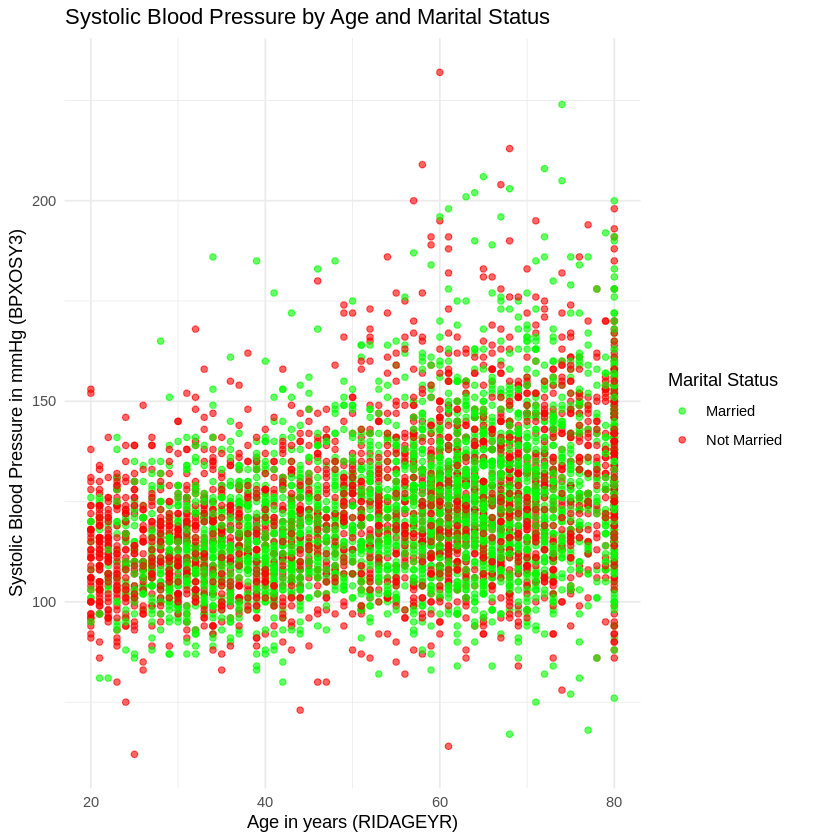

In [10]:
# Merge varibles together and drop missing values
q3 <- merged %>% select(BPXOSY3, RIDAGEYR, married) %>% na.omit()
q3 <- q3 %>% mutate(
  marital_binary = ifelse(married == 1, "Married", "Not Married")
)

# Fit linear regression
model <- lm(BPXOSY3 ~ RIDAGEYR + married, data = q3)

# Regression summary
summary(model)

# Scatter plot
ggplot(q3, aes(x = RIDAGEYR, y = BPXOSY3, color = marital_binary)) +
  geom_point(alpha = 0.6) +
  scale_color_manual(values = c("Married" = "green", "Not Married" = "red")) +
  labs(
    title = "Systolic Blood Pressure by Age and Marital Status",
    x = "Age in years (RIDAGEYR)",
    y = "Systolic Blood Pressure in mmHg (BPXOSY3)",
    color = "Marital Status"
  ) +
  theme_minimal()

# Results
p_value <- summary(model)$coefficients["married", "Pr(>|t|)"]

if (p_value < 0.05) {
  cat("Result is statistically significant (p < 0.05).\n")
} else {
  cat("Result is not statistically significant (p ≥ 0.05).\n")
}


   - **Question 4**: "Is there a **correlation** between self-reported weight and minutes of sedentary behavior?"  
     - Variables: `WHD020` (self-reported weight, cleaned) and `PAD680` (sedentary behavior time, cleaned).

Pearson r = 0.156, p = 1.699e-44


`geom_smooth()` using formula = 'y ~ x'


Result: There is a correlation between self-reported weight and minutes of sedentary behavior (p < 0.05).
Correlation strength: weak


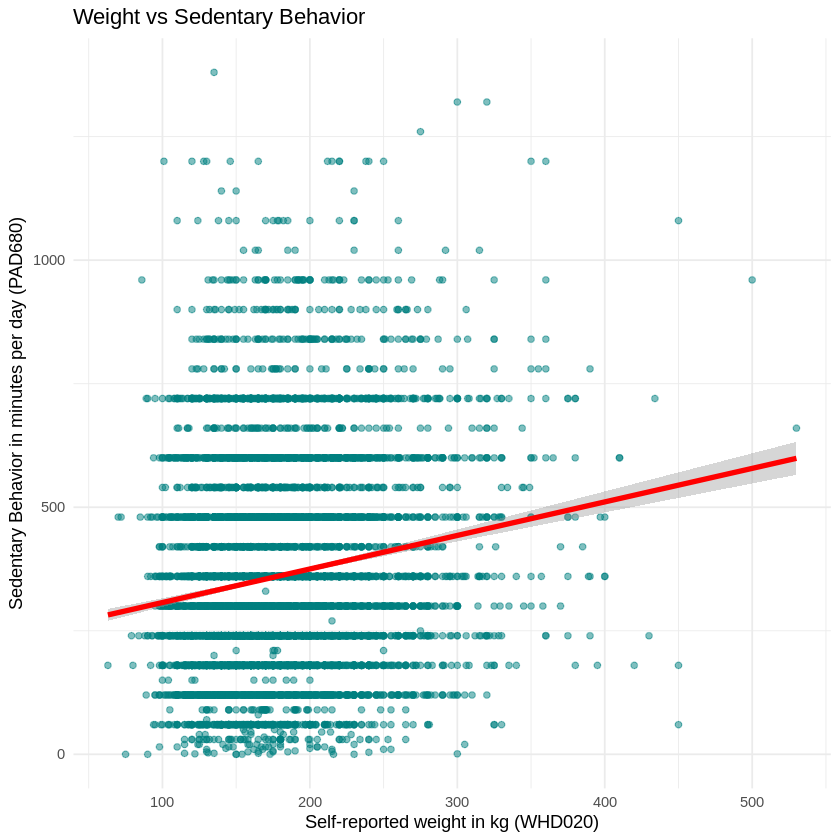

In [11]:
# Merge varibles together and drop missing values
q4 <- merged %>% select(WHD020, PAD680) %>% na.omit()

# Conduct pearson correlation
cor_res <- cor.test(q4$WHD020, q4$PAD680, method = "pearson")
r <- cor_res$estimate
p <- cor_res$p.value

cat(sprintf("Pearson r = %.3f, p = %.4g\n", r, p))

# Scatter plot
ggplot(q4, aes(x = WHD020, y = PAD680)) +
  geom_point(alpha = 0.5, color = "#008080") +
  geom_smooth(method = "lm", color = "#FF0000", linewidth = 1.5) +
  labs(
    x = "Self-reported weight in kg (WHD020)",
    y = "Sedentary Behavior in minutes per day (PAD680)",
    title = "Weight vs Sedentary Behavior"
  ) +
  theme_minimal()

# Results
if (p < 0.05) {
  cat("Result: There is a correlation between self-reported weight and minutes of sedentary behavior (p < 0.05).\n")
} else {
  cat("Result: There is no correlation between self-reported weight and minutes of sedentary behavior (p ≥ 0.05).\n")
}

strength <- ifelse(abs(r) < 0.3, "weak",
                   ifelse(abs(r) < 0.5, "moderate", "strong"))
cat(sprintf("Correlation strength: %s\n", strength))

   - **Question 5 (Creative Analysis)**: Develop your own unique question using at least one of the variables listed above. Ensure that your question can be answered using one of the following tests: chi-square, t-test, ANOVA, or correlation. Clearly state your question, explain why you chose the test, and document your findings.

   -"Is there an association between education level and being overweight?"
     - Variables: `DMDEDUC2 ` (education level) and `WHD020` (self-reported weight, cleaned).
   


In [12]:
# Merge varibles together and drop missing values
q5 <- merged %>% select(WHD020, education) %>% na.omit()
q5 <- q5 %>% mutate(
  overweight = ifelse(WHD020 >= 80, "Overweight", "Not Overweight")
)

# Create contingency table
table_q5 <- table(q5$education, q5$overweight)

# Rename table rows and columns
rownames(table_q5) <- c("Less than bachelor", "Bachelor or higher")
colnames(table_q5) <- c("Not Overweight", "Overweight")

# Conduct Chi-square test to see association
chi_res <- chisq.test(table_q5)

# Display table
print(table_q5)
cat("\n")

cat(sprintf("Chi-square statistic = %.3f\n", chi_res$statistic))
cat(sprintf("Degrees of freedom = %d\n", chi_res$parameter))
cat(sprintf("P-value = %.4g\n", chi_res$p.value))
cat(sprintf("Sample size (n) = %d\n", nrow(q5)))

# Results
if (chi_res$p.value < 0.05) {
  cat("Result: There is an association between education level and overweight status (p < 0.05).\n")
} else {
  cat("Result: There is no association between education level and overweight status (p ≥ 0.05).\n")
}

Warning message in chisq.test(table_q5):
“Chi-squared approximation may be incorrect”


                    
                     Not Overweight Overweight
  Less than bachelor              5       5072
  Bachelor or higher              0       2599

Chi-square statistic = 1.272
Degrees of freedom = 1
P-value = 0.2594
Sample size (n) = 7676
Result: There is no association between education level and overweight status (p ≥ 0.05).
